In [1]:
import tensorflow as tf 
print("done")

done


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import os
import cv2
from sklearn.model_selection import train_test_split


In [13]:
# Function to load and preprocess data
def load_data(data_dir, img_size=(224, 224)):
    labels = []
    images = []
    classes = sorted(os.listdir(data_dir))  # Ensure consistent label order
    
    for label, disease in enumerate(classes):
        disease_dir = os.path.join(data_dir, disease)
        
        # Check if it's a directory
        if not os.path.isdir(disease_dir):
            continue
        
        for img_name in os.listdir(disease_dir):
            img_path = os.path.join(disease_dir, img_name)
            
            # Skip GIFs or unreadable files
            if img_name.lower().endswith('.gif'):
                print(f"Skipping GIF file: {img_path}")
                continue

            img = cv2.imread(img_path)
            
            # Handle unreadable images
            if img is None:
                print(f"Warning: Unable to load image at {img_path}")
                continue
            
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

# Set dataset path
data_dir = r"C:\Users\DELL\Desktop\Datasets\ForClassification\wdd2017"

# Load data
train_images, train_labels = load_data(os.path.join(data_dir, "Training"))
test_images, test_labels = load_data(os.path.join(data_dir, "Testing"))
validation_images, validation_labels = load_data(os.path.join(data_dir, "Validation"))

# Normalize image data
train_images = train_images / 255.0
test_images = test_images / 255.0
validation_images = validation_images / 255.0


Skipping GIF file: C:\Users\DELL\Desktop\Datasets\ForClassification\wdd2017\Training\Loose_Smut\3181.gif
Skipping GIF file: C:\Users\DELL\Desktop\Datasets\ForClassification\wdd2017\Training\Loose_Smut\3191.gif
Skipping GIF file: C:\Users\DELL\Desktop\Datasets\ForClassification\wdd2017\Training\Loose_Smut\3271.gif
Skipping GIF file: C:\Users\DELL\Desktop\Datasets\ForClassification\wdd2017\Training\Loose_Smut\6261.gif
Skipping GIF file: C:\Users\DELL\Desktop\Datasets\ForClassification\wdd2017\Training\Loose_Smut\6271.gif
Skipping GIF file: C:\Users\DELL\Desktop\Datasets\ForClassification\wdd2017\Training\Loose_Smut\6351.gif
Skipping GIF file: C:\Users\DELL\Desktop\Datasets\ForClassification\wdd2017\Testing\Loose_Smut\0121.gif
Skipping GIF file: C:\Users\DELL\Desktop\Datasets\ForClassification\wdd2017\Testing\Loose_Smut\0131.gif
Skipping GIF file: C:\Users\DELL\Desktop\Datasets\ForClassification\wdd2017\Testing\Loose_Smut\0191.gif


In [21]:
# Convert labels to categorical for multi-class classification
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Ensure labels are integers before one-hot encoding
train_labels = np.array([np.argmax(label) if label.ndim > 1 else label for label in train_labels])
test_labels = np.array([np.argmax(label) if label.ndim > 1 else label for label in test_labels])
validation_labels = np.array([np.argmax(label) if label.ndim > 1 else label for label in validation_labels])

# Convert labels to categorical for multi-class classification
num_classes = len(np.unique(train_labels))
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)
validation_labels = to_categorical(validation_labels, num_classes)

# Build the model using VGG16 for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

In [22]:
# Define custom classification model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [23]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# Data augmentation for improved generalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(train_images)

# Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=30,
    validation_data=(validation_images, validation_labels)
)

Epoch 1/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 1361s 11s/step - accuracy: 0.6353 - loss: 0.9009 - val_accuracy: 0.9564 - val_loss: 0.1771
Epoch 2/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 1130s 9s/step - accuracy: 0.7775 - loss: 0.5452 - val_accuracy: 0.9666 - val_loss: 0.1344
Epoch 3/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 1083s 9s/step - accuracy: 0.8028 - loss: 0.4798 - val_accuracy: 0.9828 - val_loss: 0.0806
Epoch 4/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 1120s 9s/step - accuracy: 0.8403 - loss: 0.4060 - val_accuracy: 0.9828 - val_loss: 0.0797
Epoch 5/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 1101s 9s/step - accuracy: 0.8687 - loss: 0.3422 - val_accuracy: 0.9757 - val_loss: 0.0934
Epoch 6/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 1077s 9s/step - accuracy: 0.8748 - loss: 0.3178 - val_accuracy: 0.9797 - val_loss: 0.0643
Epoch 7/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 1092s 9s/step - accuracy: 0.8909 - loss: 0.3007 - val_accuracy: 0.9889 - val_loss: 0.0615
Epoch 8/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 1026s 8s/step - accuracy: 0.8932 - loss: 0.2510 -

23/23 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.5609 - loss: 2.3119
Test Accuracy: 81.72%


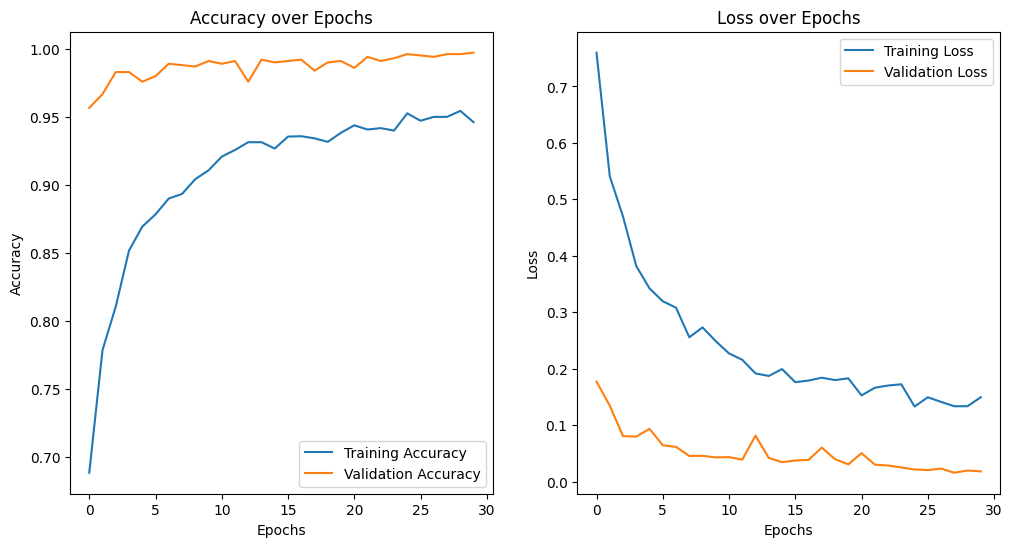

23/23 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step


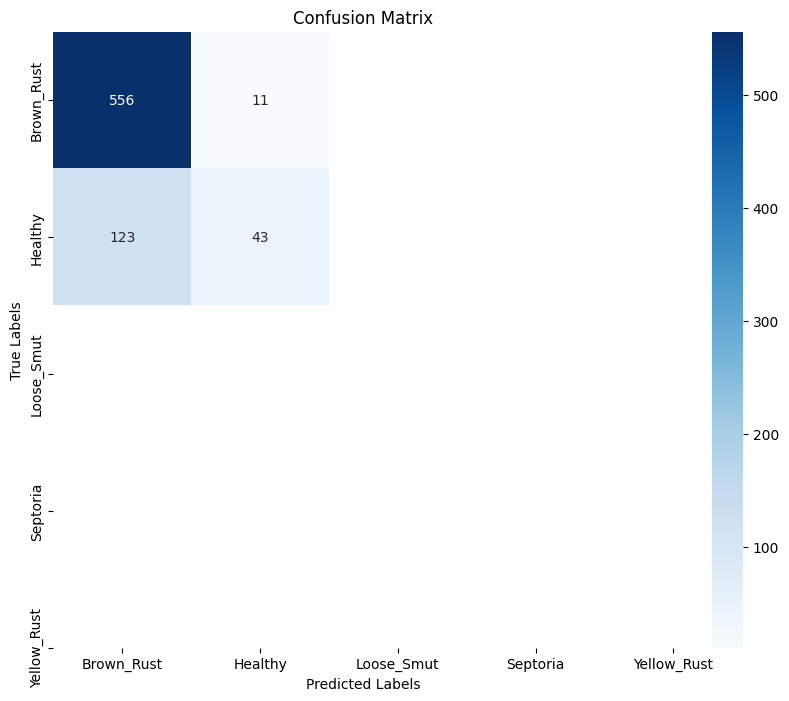

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       567
           1       0.80      0.26      0.39       166

    accuracy                           0.82       733
   macro avg       0.81      0.62      0.64       733
weighted avg       0.81      0.82      0.78       733



In [25]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Classification report and confusion matrix
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(os.listdir(os.path.join(data_dir, "Training"))),
            yticklabels=sorted(os.listdir(os.path.join(data_dir, "Training"))))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

In [26]:
print("Done")

Done


23/23 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 131s 6s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step
Test Accuracy with TTA: 81.86%
High Confidence Accuracy (Confidence >= 0.7): 82.86%


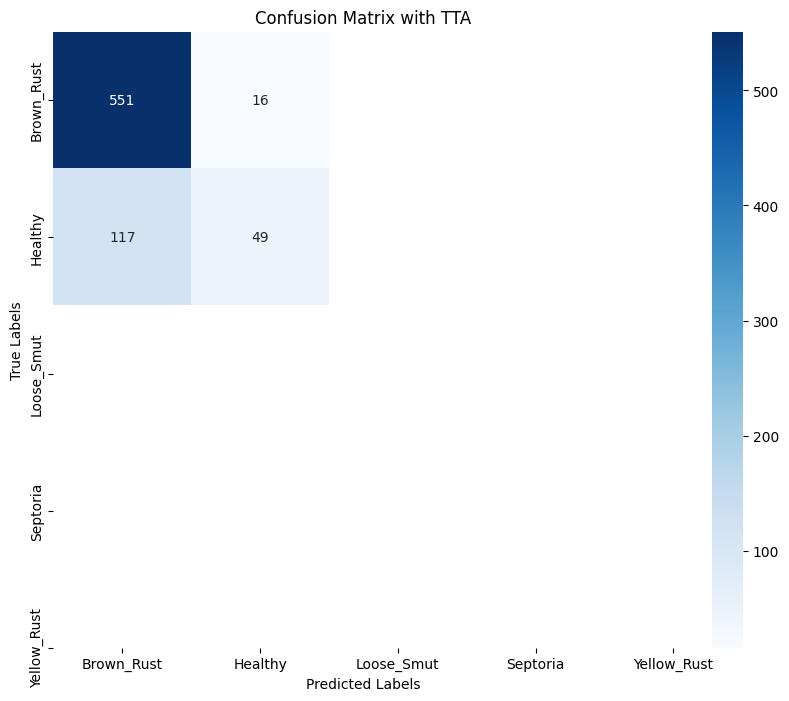

Classification Report with TTA:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       567
           1       0.75      0.30      0.42       166

    accuracy                           0.82       733
   macro avg       0.79      0.63      0.66       733
weighted avg       0.81      0.82      0.79       733



In [27]:
# Test-Time Data Augmentation (TTA) for Robust Predictions
augmented_predictions = []

# Apply augmentations to test images and average predictions
for i in range(5):  # Number of augmentation runs
    augmented_images = datagen.flow(test_images, shuffle=False, batch_size=len(test_images))
    augmented_predictions.append(model.predict(augmented_images[0]))

# Average the predictions from all augmented versions
tta_predictions = np.mean(augmented_predictions, axis=0)

# Convert predictions to class labels
tta_pred_classes = np.argmax(tta_predictions, axis=1)

# Compute final accuracy after TTA
tta_acc = np.mean(tta_pred_classes == np.argmax(test_labels, axis=1))
print(f"Test Accuracy with TTA: {tta_acc * 100:.2f}%")

# Confidence Thresholding
confidence_threshold = 0.7
high_confidence_preds = np.max(tta_predictions, axis=1) >= confidence_threshold
confident_predictions = tta_pred_classes[high_confidence_preds]
confident_true_labels = np.argmax(test_labels, axis=1)[high_confidence_preds]
confident_accuracy = np.mean(confident_predictions == confident_true_labels)

print(f"High Confidence Accuracy (Confidence >= {confidence_threshold}): {confident_accuracy * 100:.2f}%")

# Updated Confusion Matrix and Report with TTA
conf_matrix_tta = confusion_matrix(np.argmax(test_labels, axis=1), tta_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_tta, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(os.listdir(os.path.join(data_dir, "Training"))),
            yticklabels=sorted(os.listdir(os.path.join(data_dir, "Training"))))
plt.title('Confusion Matrix with TTA')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Updated Classification Report
print("Classification Report with TTA:")
print(classification_report(np.argmax(test_labels, axis=1), tta_pred_classes))
